# spinal_test1.ipynb
First test of the delegational learning rule in the context of the spinal cord project.

Let $S_F, S_P, S_{P-F}, M_C$ denote the regions of the cortical model, and $s_F, s_P, s_{P-F}, m_C$ denote their current activities.
Assume that each unit $u_j$ in $M_C$ is associated with a vector $\bar{v}_j$, and that the ouput of the plant is $p = \sum_j u_j \bar{v}_j$. We also set $s_F = p$. The rule should be such that $p \approx s_P$.

The plant $P$ can be implemented as a population of linear units.
If the connection matrix from $M_C$ to $P$ is called $W$, then
$\bar{v}_j = (W_{1,j}, W_{2,j}, ..., W_{n,j})^T \equiv W_{:,j}$. 

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
# Create the neuronal populations
N = 8 # size of each population
des_pat = np.zeros(N) # desired pattern in SP
des_pat[np.arange(0,N,2)] = 1. # a one every other entry

net_params = {'min_delay' : 0.01,
              'min_buff_size' : 10 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.,
             'slope' : 1.,
             'init_val' : 0.5,
             'tau' : 0.05 }
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'function' : lambda x: None }
SPF1_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.3,
              'slope' : 1.5,
              'init_val' : 0.3,
              'tau_fast': 0.08,
              'tau_mid': 0.5,
              'tau_slow' : 2.,
              'tau' : 0.05 }
SPF2_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.3,
              'slope' : 1.5,
              'init_val' : 0.3,
              'tau_fast': 0.08,
              'tau_mid': 0.5,
              'tau_slow' : 2.,
              'tau' : 0.05,}
P_params = {'type' : unit_types.linear,
            'init_val' : 0.,
            'tau' : 0.05 }
M_params = {'type' : unit_types.sigmoidal,
            'thresh' : 0.3,
            'slope' : 1.5,
            'init_val' : 0.2,
            'tau' : 0.05,
            'mu': 0.,
            'sigma' : 0.02,
            'lambda' : 1.,
            'tau_fast': 0.1,
            'tau_mid' : 0.4,
            'tau_slow' : 2.,
            'delay' : 0.11 }

net = network(net_params)
SF = net.create(N, SF_params)
SP = net.create(N, SP_params)
SPF1 = net.create(N, SPF1_params)
SPF2 = net.create(N, SPF2_params)
P = net.create(N, P_params)
ME = net.create(N, M_params)
MI = net.create(N, M_params)

# set the pattern in SP
def make_fun(idx):
    return lambda t: des_pat[idx]
for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# Create the connections. See note on "detecting layer distances" in cortex wiki
SF__SPF1_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SF__SPF2_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SF__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SF__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF1_conn = {'rule' : "one_to_one",
                'delay' : 0.02 }
SP__SPF2_conn = {'rule' : "one_to_one",
                'delay' : 0.02 }
SP__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SPF1__ME_conn = {'rule': 'all_to_all',
                'delay': 0.02 }
SPF2__ME_conn = SPF1__ME_conn
SPF1__MI_conn = SPF1__ME_conn
SPF2__MI_conn = SPF1__ME_conn
SPF1__ME_syn = {'type' : synapse_types.diff_hebbsnorm,
                'lrate': 10.,
                'post_delay': 10,
                'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }
SPF2__ME_syn = SPF1__ME_syn
SPF1__MI_syn = SPF1__ME_syn
SPF2__MI_syn = SPF1__ME_syn
# Specify the connection matrix from ME/MI to P
W = 5.*np.eye(N)
ME__P_conn = {'rule': 'all_to_all',
              'delay': 0.02 }
ME__P_syn = {'type': synapse_types.static,
             'init_w' : W.flatten() }
MI__P_conn = {'rule': 'all_to_all',
              'delay': 0.02 }
MI__P_syn = {'type': synapse_types.static,
             'init_w' : -W.flatten() }
P__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 3. }
# Optional mutual inhibition in M
ME__ME_conn = {'rule': 'all_to_all',
               'allow_autapses' : False,
               'delay' : 0.02 }
ME__ME_syn = {'type' : synapse_types.cov,
              'lrate' : -0.1,
              'init_w' : -0.01 }
MI__MI_conn = ME__ME_conn
MI__MI_syn = ME__ME_syn
ME__MI_conn = {'rule' : 'one_to_one',
               'delay' : 0.02 }
ME__MI_syn = {'type' : synapse_types.static, 
              'init_w' : -1.}
MI__ME_conn = ME__MI_conn
MI__ME_syn = ME__MI_syn

net.connect(SF, SPF1, SF__SPF1_conn, SF__SPF1_syn)
net.connect(SF, SPF2, SF__SPF2_conn, SF__SPF2_syn)
net.connect(SP, SPF1, SP__SPF1_conn, SP__SPF1_syn)
net.connect(SP, SPF2, SP__SPF2_conn, SP__SPF2_syn)
net.connect(SPF1, ME, SPF1__ME_conn, SPF1__ME_syn)
net.connect(SPF1, MI, SPF1__MI_conn, SPF1__MI_syn)
net.connect(SPF2, ME, SPF2__ME_conn, SPF2__ME_syn)
net.connect(SPF2, MI, SPF2__MI_conn, SPF2__MI_syn)
net.connect(ME, P, ME__P_conn, ME__P_syn)
net.connect(MI, P, MI__P_conn, MI__P_syn)
net.connect(P, SF, P__SF_conn, P__SF_syn)
net.connect(ME, ME, ME__ME_conn, ME__ME_syn)
net.connect(MI, MI, MI__MI_conn, MI__MI_syn)
net.connect(ME, MI, ME__MI_conn, ME__MI_syn)
net.connect(MI, ME, MI__ME_conn, MI__ME_syn)

In [3]:
start_time = time.time()
times, data, _  = net.run(5.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 4.172043561935425 seconds


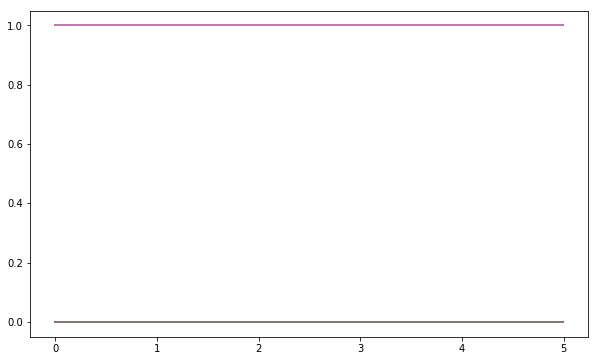

[1. 0. 1. 0. 1. 0. 1. 0.]


In [4]:
# SP
SP_fig = plt.figure(figsize=(10,6))
SP_data = np.array(data[SP])
plt.plot(times, SP_data.transpose())
plt.show()
print(SP_data[:,-1])

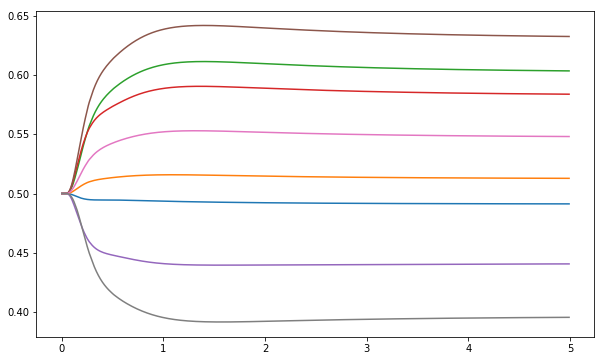

[0.4912556  0.51279198 0.60336094 0.58371907 0.44065476 0.63237053
 0.548033   0.39561209]


In [5]:
# SF
SF_fig = plt.figure(figsize=(10,6))
SF_data = np.array(data[SF])
plt.plot(times, SF_data.transpose())
plt.show()
print(SF_data[:,-1])

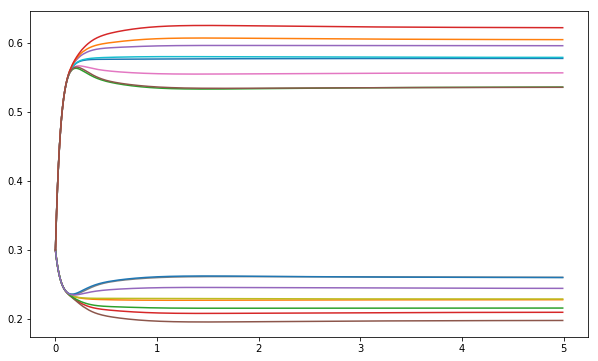

[0.57764333 0.22807541 0.53615632 0.20988071 0.59605005 0.19803017
 0.55673088 0.26050041 0.22915186 0.57913185 0.26020984 0.60483316
 0.21601642 0.62214241 0.24454796 0.53578106]


In [6]:
# SPF
SPF_fig = plt.figure(figsize=(10,6))
SPF_data = np.array(data[SPF1+SPF2])
plt.plot(times, SPF_data.transpose())
plt.show()
print(SPF_data[:,-1])

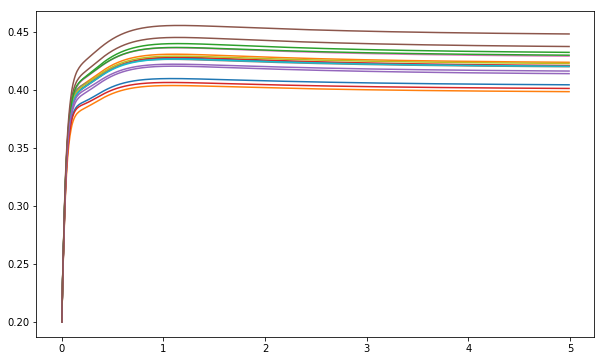

[0.42035714 0.42367134 0.43223031 0.42089914 0.41390077 0.43726953
 0.42896789 0.41984589 0.4226926  0.42026698 0.40429267 0.39838469
 0.42979567 0.40114405 0.41613494 0.44808079]


In [7]:
# M
M_fig = plt.figure(figsize=(10,6))
M_data = np.array(data[ME+MI])
plt.plot(times, M_data.transpose())
plt.show()
print(M_data[:,-1])

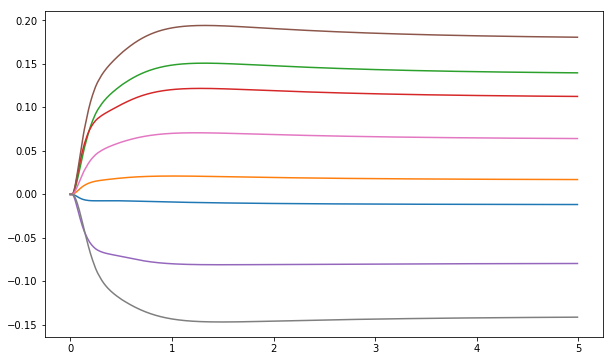

[-0.01166902  0.01704032  0.13975737  0.11262816 -0.07948786  0.18071176
  0.06420259 -0.1412167 ]


In [8]:
# P
P_fig = plt.figure(figsize=(10,6))
P_data = np.array(data[P])
plt.plot(times, P_data.transpose())
plt.show()
print(P_data[:,-1])

In [9]:
for idx, syn in enumerate(net.syns[ME[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> ME, w=%f'%(idx, pre_pop, pre_id, syn.w))

0) SPF1 (16) --> ME, w=0.099319
1) SPF1 (17) --> ME, w=0.019509
2) SPF1 (18) --> ME, w=0.125369
3) SPF1 (19) --> ME, w=0.016753
4) SPF1 (20) --> ME, w=0.103457
5) SPF1 (21) --> ME, w=0.026936
6) SPF1 (22) --> ME, w=0.112418
7) SPF1 (23) --> ME, w=0.037745
8) SPF2 (24) --> ME, w=0.021135
9) SPF2 (25) --> ME, w=0.128014
10) SPF2 (26) --> ME, w=0.039213
11) SPF2 (27) --> ME, w=0.101800
12) SPF2 (28) --> ME, w=0.043591
13) SPF2 (29) --> ME, w=0.146937
14) SPF2 (30) --> ME, w=0.047428
15) SPF2 (31) --> ME, w=0.094869
16) erroneous (41) --> ME, w=-0.026008
17) erroneous (42) --> ME, w=-0.026310
18) erroneous (43) --> ME, w=-0.025903
19) erroneous (44) --> ME, w=-0.025644
20) erroneous (45) --> ME, w=-0.026498
21) erroneous (46) --> ME, w=-0.026200
22) erroneous (47) --> ME, w=-0.025880
23) erroneous (48) --> ME, w=-1.000000


In [10]:
for idx, syn in enumerate(net.syns[MI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MI, w=%f'%(idx, pre_pop, pre_id, syn.w))

0) SPF1 (16) --> MI, w=0.115680
1) SPF1 (17) --> MI, w=0.050099
2) SPF1 (18) --> MI, w=0.107013
3) SPF1 (19) --> MI, w=0.005928
4) SPF1 (20) --> MI, w=0.118649
5) SPF1 (21) --> MI, w=0.039096
6) SPF1 (22) --> MI, w=0.131301
7) SPF1 (23) --> MI, w=0.016233
8) SPF2 (24) --> MI, w=0.031780
9) SPF2 (25) --> MI, w=0.112096
10) SPF2 (26) --> MI, w=0.054452
11) SPF2 (27) --> MI, w=0.103537
12) SPF2 (28) --> MI, w=0.022399
13) SPF2 (29) --> MI, w=0.121109
14) SPF2 (30) --> MI, w=0.055260
15) SPF2 (31) --> MI, w=0.098444
16) erroneous (49) --> MI, w=-0.026026
17) erroneous (50) --> MI, w=-0.025440
18) erroneous (51) --> MI, w=-0.025216
19) erroneous (52) --> MI, w=-0.026379
20) erroneous (53) --> MI, w=-0.025327
21) erroneous (54) --> MI, w=-0.025877
22) erroneous (55) --> MI, w=-0.027045
23) erroneous (40) --> MI, w=-1.000000


# PART 2
Testing the `test_oscillator` model.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
net_params = {'min_delay' : 0.1,
              'min_buff_size' : 40 }
unit_params = {'type' : unit_types.test_oscillator,
               'integ_meth' : 'euler_maru',
               #'integ_meth' : 'odeint',
               'tau' : .5,
               'multidim' : True,
               'init_val' : [[1., 1.], [0, np.sqrt(2.)]],
               'mu' : 0.,
               'sigma' : 1.}
net = network(net_params)
net.create(2, unit_params)

[0, 1]

In [3]:
start_time = time.time()
#times, data, _  = net.flat_run(20.)
times, data, _  = net.run(20.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 0.11466431617736816 seconds


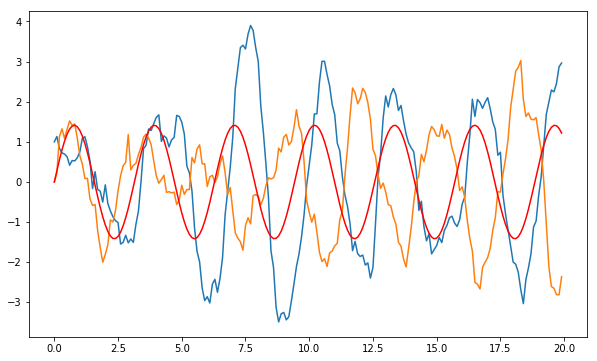

In [4]:
fig = plt.figure(figsize=(10,6))
plt.plot(times, data.transpose())
plt.plot(times, np.sqrt(2.)*np.sin(2.*times), 'r')
plt.show()

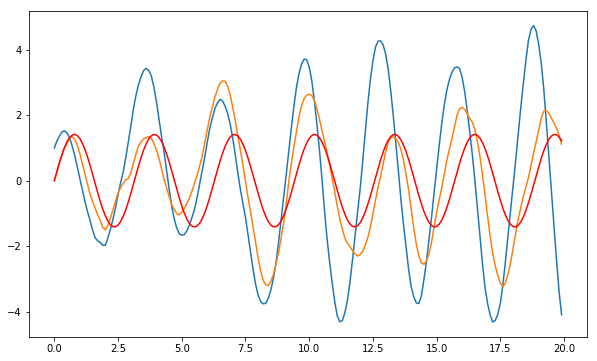

In [4]:
fig = plt.figure(figsize=(10,6))
plt.plot(times, data.transpose())
plt.plot(times, np.sqrt(2.)*np.sin(2.*times), 'r')
plt.show()